In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import torch
import torch.nn as nn
from torch.nn import functional as F
from itertools import groupby
from operator import itemgetter
import datetime
import math
import pandas as pd
import numpy as np
import pytz

file1 = "all_training_data_sorted.csv"
north = 'data_north_p.csv'
east = 'data_east_p.csv'
south = 'data_south_p.csv'
west = 'data_west_p.csv'
device = 'cuda'

tz = pytz.timezone('Europe/Berlin')

def convert_to_weeknumber_cossin(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    dt_local = date.astimezone(tz)
    week_number = dt_local.isocalendar()[1]
    sin_week = np.sin(2*np.pi*week_number/53).astype(np.float32)
    cos_week = np.cos(2*np.pi*week_number/53).astype(np.float32)
    return sin_week, cos_week

def convert_to_hour_cossin(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp)
    dt_local = date.astimezone(tz)
    hour = dt_local.hour
    sin_hour = np.sin(2*np.pi*hour/24).astype(np.float32)
    cos_hour = np.cos(2*np.pi*hour/24).astype(np.float32)
    return sin_hour, cos_hour


def closest_timestamp(data, timestamp):
    closest_timestamp = min(data.keys(), key=lambda t: abs(t - timestamp))
    return data[closest_timestamp]

def read_csv(file):
    data = pd.read_csv(file)
    for index, row in data.iterrows():
        yield row['time'] / 1_000_000_000, row['tags'], row['min'], row['max'], row['mean'] 

def read_csv_meteostat(file):
    data = pd.read_csv(file)
    timestamp_dict = {}
    for index, row in data.iterrows():
        if not pd.isna(row['time']) and not pd.isna(row['pres']):
            timestamp = row['time'] / 1_000_000_000
            timestamp_dict[timestamp] = row['pres']                            
    return timestamp_dict

def group_column(file, north, east, south, west):
    meteostat_data_north = read_csv_meteostat(north)
    meteostat_data_east = read_csv_meteostat(east)
    meteostat_data_south = read_csv_meteostat(south)
    meteostat_data_west = read_csv_meteostat(west)
    
    for timestamp, values in groupby(read_csv(file), key=itemgetter(0)):
        pres_value_north = closest_timestamp(meteostat_data_north, timestamp)
        pres_value_east = closest_timestamp(meteostat_data_east, timestamp)
        pres_value_south = closest_timestamp(meteostat_data_south, timestamp)
        pres_value_west = closest_timestamp(meteostat_data_west, timestamp)
        
        d = {}
        for (_, topic, value_min, value_max, value_mean) in values:
            if not math.isnan(value_min) and not math.isnan(value_max) and not math.isnan(value_mean):
                d[topic] = {'min': value_min, 'max': value_max, 'mean': value_mean}
        
        try:
            week_values = convert_to_weeknumber_cossin(timestamp)
            hour_values = convert_to_hour_cossin(timestamp)
            yield (
                (d["topic=Pfullingen/temperature"]['mean'] - 20) / 35, 
                (d["topic=Pfullingen/hourlyrain"]['mean']) / 10, 
                (d["topic=Pfullingen/windspeed"]['mean']- 5) / 10,
                (d["topic=Pfullingen/solarradiation"]['max'] - 500) / 1000,
                (d["topic=Pfullingen/solarradiation"]['mean'] - 500) / 1000, 
                (d["topic=Pfullingen/pressure"]['mean'] - 500) / 1000,
                (d["topic=Pfullingen/winddir"]['mean'] - 180) / 360,
                (d["topic=Pfullingen/humidity"]['mean'] - 50) / 100,
                hour_values[0],
                hour_values[1],
                week_values[0],
                week_values[1],
                float((pres_value_north - 500) / 1000),
                float((pres_value_east - 500) / 1000),
                float((pres_value_south - 500) / 1000),
                float((pres_value_west - 500) / 1000)
                
            )
        except KeyError:
            pass

In [137]:
class WeatherForecast(nn.Module):
    def __init__(self, input_features, hidden_dim, num_layers, output_dim, dropout_rate=0.0):
        super(WeatherForecast, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_features, hidden_dim, num_layers, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout1(out)
        out = self.fc(out[:, -1, :])
        return out

In [6]:
imported_data_raw = list(group_column(file1, north, east, south, west))
imported_data = torch.tensor(imported_data_raw)


In [59]:
imported_data_backup = imported_data.clone()

In [60]:
imported_data[:, 12] -= imported_data[:, 5]
imported_data[:, 13] -= imported_data[:, 5]
imported_data[:, 14] -= imported_data[:, 5]
imported_data[:, 15] -= imported_data[:, 5]

imported_data[:, 12] *= 45
imported_data[:, 13] *= 45
imported_data[:, 14] *= 45
imported_data[:, 15] *= 45

In [61]:
imported_data.shape

torch.Size([18664, 16])

In [28]:
def create_sequences(data, input_hours, output_hours, output_features):
    xs = []
    ys = []

    for i in range(data.size(0)-(input_hours+output_hours)):
        x = data[i:(i+input_hours)]
        y = data[(i+input_hours):(i+input_hours+output_hours),:output_features]
        xs.append(x)
        ys.append(y)

    return torch.stack(xs), torch.stack(ys).view(-1, output_hours * output_features)

In [29]:
input_hours = 72
input_features = 16
output_hours = 24
output_features = 16


In [62]:
X, y = create_sequences(imported_data, input_hours, output_hours, output_features)
print(X.shape)
print(y.shape)

torch.Size([18568, 72, 16])
torch.Size([18568, 384])


In [114]:
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader

# Calculate split sizes
num_samples = len(X)
num_train = round(num_samples * 0.8)
num_val = num_samples - num_train

# Create data sets
train_data, val_data = random_split(TensorDataset(X, y), [num_train, num_val])

batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [115]:
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)
    break

torch.Size([32, 72, 16]) torch.Size([32, 384])


In [138]:
#model with LSTM
output_dim = output_hours * output_features
model = WeatherForecast(input_features=input_features, hidden_dim=60, num_layers=8, output_dim=output_dim).to(device)

In [155]:
#LSTM training loop
import torch.optim as optim
model.dropout1.p = 0.0
num_epochs = 10
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(num_epochs*.8), gamma=0.1)
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
    scheduler.step()
    model.eval()
    with torch.no_grad():
        val_losses = []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item(),avg_val_loss))
    #best so far Train Loss: 0.0012, Validation Loss: 0.0012

Epoch [1/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [2/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [3/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [4/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [5/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [6/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [7/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [8/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [9/10], Train Loss: 0.0010, Validation Loss: 0.0012
Epoch [10/10], Train Loss: 0.0010, Validation Loss: 0.0012


In [162]:
file1_forecast = "test_sorted.csv"
north_forecast = 'data_north_p_test_latest.csv'
east_forecast = 'data_east_p_test_latest.csv'
south_forecast = 'data_south_p_test_latest.csv'
west_forecast = 'data_west_p_test_latest.csv'

In [168]:
file1_forecast = "test_before_coldfront_sorted.csv"
north_forecast = 'data_north_p_test_latest_before_coldfront.csv'
east_forecast = 'data_east_p_test_latest_before_coldfront.csv'
south_forecast = 'data_south_p_test_latest_before_coldfront.csv'
west_forecast = 'data_west_p_test_latest_before_coldfront.csv'

In [169]:
#forecast LSTM
model.eval()
test_data_raw = list(group_column(file1_forecast, north_forecast, east_forecast, south_forecast, west_forecast))
test_data = torch.tensor(test_data_raw, device=device)
eval_data = test_data[-input_hours:]
eval_data = eval_data.view(1,input_hours,input_features)
output = model(eval_data)
model.train()

WeatherForecast(
  (lstm): LSTM(16, 60, num_layers=8, batch_first=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=60, out_features=384, bias=True)
)

In [170]:
eval_data = test_data[-input_hours:].view(1,-1,input_features)
eval_data.shape

torch.Size([1, 72, 16])

In [171]:
output.shape

torch.Size([1, 384])

In [172]:
input_temperature = eval_data.view(input_hours,16)[:,0]*35+20
temperature = output.view(output_hours,output_features)[:,0]*35+20
#rain = output.view(24,5)[:,1]*10
#wind = output.view(24,5)[:,2]*10+5
#solmax = output.view(24,5)[:,3]*1000+500
#solmean = output.view(24,5)[:,4]*1000+500
sin = output.view(output_hours,output_features)[:,8]
forecast_temperature = temperature.cpu().detach().numpy()
input_temperature = input_temperature.cpu().detach().numpy()
sin = sin.cpu().detach().numpy()

Text(0, 0.5, 'Temperature')

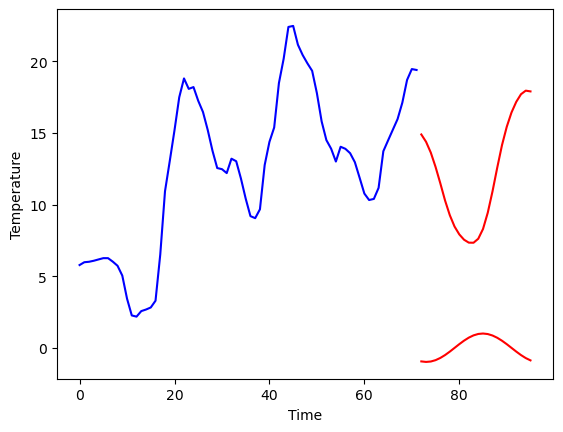

In [173]:
import matplotlib.pyplot as plt
# Generate x-axis values for the plots
x_input = range(len(input_temperature))
x_forecast = range(len(input_temperature), len(input_temperature) + len(forecast_temperature))
plt.plot(x_input, input_temperature, color='blue', label='Input Temperature')
plt.plot(x_forecast, forecast_temperature, color='red', label='Forecast Temperature')
plt.plot(x_forecast, sin, color='red', label='Forecast Temperature')


# Set labels and title
plt.xlabel('Time')
plt.ylabel('Temperature')